**Deep Learning Convolutional Neural Network** </br>

Development of a convolutional network to predict the gender of an individual whose face appears in an image.

Code developed by Marcelo Ferrer and Aymen Merchaoui

The notebook is divided in sections with the following structure:
1. Imports, declarations and configuration
2. Dataset
3. Testing </br>
    Dataset Selection</br>
    Optimizer Selection</br>
    Model Selection</br>
    Regularization and optimization</br>
    Fine-tuning</br>
4. Results</br>

## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

The constants for img_height, img_width and batch_size are defined here.

Also configuration to enable/disable the test for dataset, optimizer, models and regularization.

In [1]:
import os 

In [2]:
# For better visualization of convolutional models
os.system("pip install visualkeras")

0

In the next cell we validate that the GPU is active, as each training for the simple model takes around 25 minutes to run with GPU and without it the time for training is more than one hour each.

In [3]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.models import load_model

# Graphs
import matplotlib.pyplot as plt
import visualkeras

import shutil

from IPython.display import Image

from os import listdir
import os.path  

import numpy as np

import json

In [5]:
# Size at which images will be processed
img_height = 32
img_width = 32

batch_size = 128

# If activated test the model with original, regularization -/1 and the weights
test_dataset = False
# If activated test the optimizers
test_optimizer = False
# If activated test the models
test_models = False
# If activated test the regularizations and optimizations
test_reg = False

Load the paths and verify they exist

In [6]:
# Dataset path
PATH = 'datasets/faces/faces_dataset_train/'
PATH_TEST = 'datasets/faces/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

In [7]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 2. Dataset

In this section we load the dataset for training and validation with the provided functions. </br>
The size of the train set is 126865 rows and the training is 1000.

### Metadata access

Load the metadata information

In [8]:
with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

*** datasets/faces/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Count training images: 126865
Count test images: 1000
Image shape:  (32, 32, 3)
Label:  0


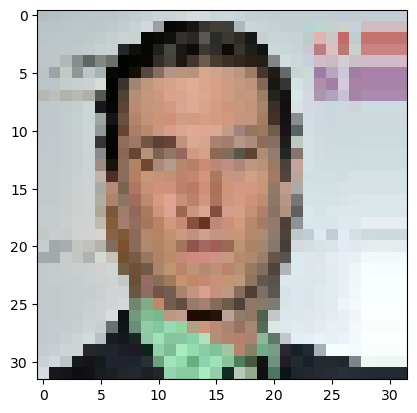

Image shape:  (32, 32, 3)
Label:  1


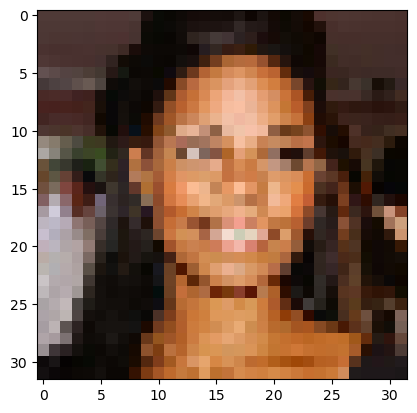

Image shape:  (32, 32, 3)
Label:  0


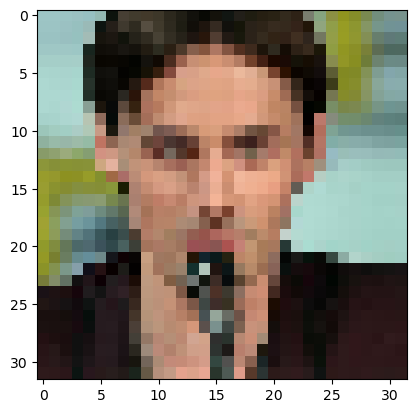

Image shape:  (32, 32, 3)
Label:  1


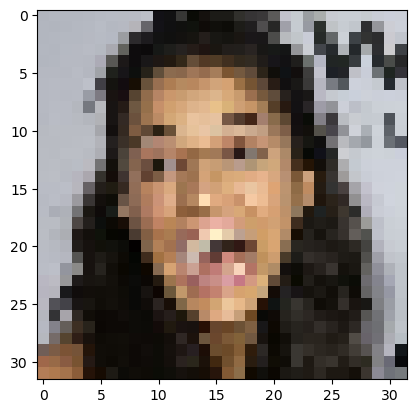

Image shape:  (32, 32, 3)
Label:  0


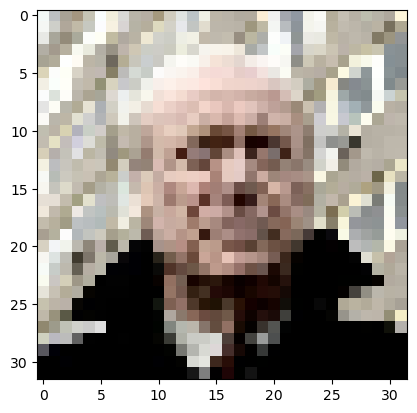

In [9]:
def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
print("***",train_metadata[0])

train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)
# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

print("Count training images:", len(train_ds))
print("Count test images:",len(test_ds))

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image.numpy())
    plt.show()

In [10]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])
print(train_metadata[1])

datasets/faces/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M
datasets/faces/faces_dataset_train/i47/nm0716347_rm278112000_1970-9-29_2013.jpg|43|M


### Dataset generation

**Data normalization**

The inputs for our models are pixels values ranging between 0 and 255 so normalizing them will be useful to help the model with the learning process. For that we can choose to normalize our input to values between -1 and 1 or between 0 and 1. </br>
For [-1,1] we need to divide the values by 255/2 to rescale in range [0,2] and then to subtract 1 from both sides. </br>
For [0,1] we just need to divide by 255. </br>
Both normalization will make it easier for the network to learn the features of the images but normalizing to [-1,1] will be better it helps more with model convergence and improves the stability of the training process.

In [11]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform_rs11 = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform_rs11 = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [12]:
# OPTIONAL: rescaling input to [0, 1]
ds_train_transform_rs01 = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/255, label))
ds_test_transform_rs01 = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/255, label))

**Data balance**

As the dataset is a little imbalance (74253 men and 52612 women), a weight strategy could be a good idea. This will assign more weight to the class with less instances so the model will learn with the same influence for both classes.

In [13]:
# OPTIONAL: sample gender weights
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
# Sample gender weights (there are 74253 men and 52612 women in the dataset)
print(sample_weights)
ds_train_transform_we = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform_we = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


In [14]:
# Combination of rescaling and weights
ds_train_transform_rs11_we = ds_train_transform_rs11.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform_rs11_we = ds_test_transform_rs11.map(lambda image, label: (image, label, sample_weights[label]))

ds_train_transform_rs01_we = ds_train_transform_rs01.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform_rs01_we = ds_test_transform_rs01.map(lambda image, label: (image, label, sample_weights[label]))

Finally we create batch for all the datasets to be used in testing.

In [15]:
ds_train_batch_or = ds_train_transform.batch(batch_size)
ds_test_batch_or = ds_test_transform.batch(batch_size)

ds_train_batch_rs11 = ds_train_transform_rs11.batch(batch_size)
ds_test_batch_rs11 = ds_test_transform_rs11.batch(batch_size)

ds_train_batch_rs01 = ds_train_transform_rs01.batch(batch_size)
ds_test_batch_rs01 = ds_test_transform_rs01.batch(batch_size)

ds_train_batch_we = ds_train_transform_we.batch(batch_size)
ds_test_batch_we = ds_test_transform_we.batch(batch_size)

ds_train_batch_rs11_we = ds_train_transform_rs11_we.batch(batch_size)
ds_test_batch_rs11_we = ds_test_transform_rs11_we.batch(batch_size)

ds_train_batch_rs01_we = ds_train_transform_rs01_we.batch(batch_size)
ds_test_batch_rs01_we = ds_test_transform_rs01_we.batch(batch_size)

## 3. TESTING

In this section we experiment with different datasets, optimizers, models, hyperparameters and regularization to define our final model. Each sub section can be enable/disable from the configuration section. Dataset and optimizer selection where only run once, but model, regularization and optimization and fine tunning section where ran iteratively to experiment with different models and parameters.

We do not use GridSearch or RandomSearch methods because the time it takes to run only one test is large enough. Using this kind of testing takes hours or in some of our tests, exhaust the resources of our computers.

### Supplementary functions and default configuration
Supplementary functions to plot the data and return some predefined models.
Default defined optimizers and datasets.

In [16]:
# Function to print the results of the training
def print_plot(name, history):
    # summarize history for train accuracy
    fig, axs = plt.subplots(1,2)
    fig.suptitle(name + ' - Training and validation')
    fig.set_figwidth(10)
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['Loss', 'Val_loss'])
    axs[0].set_ylim([0, 0.7])
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['Accuracy', 'Val_accuracy'])
    axs[1].set_ylim([0.5, 1])
    plt.savefig('images/' + name + '.png')
    plt.show()

In [17]:
# Function to get the basic model
def get_simple_model():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [18]:
# Function to get the best model from the test section
def get_best_test_model():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [19]:
# Function to get the best model from the regularization section
def get_best_reg_model():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu", kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# Function to get the callbacks for the test of the models
def get_callbacks(name):
    # This is to save computational power as a 15 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=15, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1)
            ]

In [21]:
# Function to get the callbacks for the test of the models
def get_full_callbacks(name):
    # This is to save computational power as a 15 epoch value without improvement we know is not going to get better
    return [EarlyStopping(monitor='val_loss', patience=15, verbose=1),
            # Save only the best model
            keras.callbacks.ModelCheckpoint(filepath="models/" + name + ".keras",save_best_only=True,monitor="val_loss", verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.00000001, cooldown=2, verbose=1)
            ]

In [22]:
# Get the default optimizer
def get_optimizer():
    return optimizers.Adamax(learning_rate=0.001)

In [23]:
# Assign the default dataset
ds_train_batch = ds_train_batch_rs11_we
ds_test_batch = ds_test_batch_rs11_we

# Create call back to use later
# If 20 epochs without improvement in the loss, stop the training
# This is to save computational power as a 20 epoch value without improvement we know is not going to get better
late_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# Reduce the learning rate if we reach a point that the validation loss does not improve more
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=0.000001, cooldown=2, verbose=1)

### Dataset selection

In this sub section we determinate which dataset to use. 

In [24]:
if test_dataset == True:
    test_history= []
    ds_names = ["original","rescaling [-1,1]","rescaling [0,1]","weights","rescaling [-1,1] weights","rescaling [0,1] weights"]
    ds_train_values= [ds_train_batch_or, ds_train_batch_rs11, ds_train_batch_rs01, ds_train_batch_we, ds_train_batch_rs11_we, ds_train_batch_rs01_we]
    ds_test_values= [ds_test_batch_or, ds_test_batch_rs11, ds_test_batch_rs01, ds_test_batch_we, ds_test_batch_rs11_we, ds_test_batch_rs01_we]

In [25]:
if test_dataset == True:
    for i in range(0,len(ds_names)):
        model = get_simple_model()

        # Weigthed metrics for weight datasets
        if (ds_names[i].__contains__("weight")):
            model.compile(optimizer=get_optimizer(),loss="binary_crossentropy", weighted_metrics=["accuracy"])
        else:
            model.compile(optimizer=get_optimizer(),loss="binary_crossentropy", metrics=["accuracy"])

        print("Testing dataset:",ds_names[i])
        test_history.append(model.fit(ds_train_values[i], epochs=30, validation_data=ds_test_values[i], callbacks=[late_stop]))

In [26]:
# Show the results of the test
if test_dataset == True:
    for i in range(0,len(ds_names)):
        print(ds_names[i]," - Acc:",max(test_history[i].history['val_accuracy']))
        print_plot(ds_names[i], test_history[i])

As no abnormalities have been detected in the comparison of the datasets (all ranges between 83 and 87 of validation accuracy with similar graphs), we can use the previously select dataset with the combination of [-1, 1] rescaling and weighting. 

For future executions of the notebook, we use the variable test_dataset in false to not repeat this test.

### Optimizer selection

In this sub section we determinate which optimizer to use. 

In [27]:
if test_optimizer == True:
    opt_names = ["RMSprop","adam","Adamax","SGD"]
    opt_values = [optimizers.RMSprop(learning_rate=0.001),optimizers.Adam(learning_rate=0.001), optimizers.Adamax(learning_rate=0.001),optimizers.SGD(learning_rate=0.01)]
    test_history= []

In [28]:
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        model = get_simple_model()

        model.compile(optimizer=opt_values[i],loss="binary_crossentropy", weighted_metrics=["accuracy"])
        print("Testing optimizer:",opt_names[i])
        # No batch size because we did it before
        test_history.append(model.fit(ds_train_batch, epochs=50, validation_data=ds_test_batch, callbacks=[late_stop, reduce_lr]))

In [29]:
if test_optimizer == True:
    for i in range(0,len(opt_names)):
        print(opt_names[i], " - Acc:", max(test_history[i].history['val_accuracy']))
        print_plot(opt_names[i], test_history[i])

In the case of RMSProp and adam, the validation loss stops improving after the first five epochs, making them very fast to converge, and in the case of SGD it takes more than 20 epochs. On the other hand, for adamax we get ten epochs before the validation loss start increasing, making it the more stable optimizer for this particular implementation.

For future executions of the notebook, we use the variable test_optimizer in false to not repeat this test.

### Model selection

In this section we do testing of different model structures and hyperparameters to reach our final model.

We save the best model to have them as history of execution but when we are not going to use them when why apply regularization. For now we just want to know what is the better structure to use it in our get_best_model function.

To train our models, we active the ModelCheckpoint callback, which will save in disk only the model when it has the best weights. To do this, it evaluates the validation loss and only save the model when it improves (in our case, when it have the less value in the binary crossentropy metric). We decide to use the validation accuracy of this instance instead of the best validation accuracy of the model to compare, as it will be the real accuracy given when the model stops learning instead of other accuracies given by epochs with a higher loss.

This was the result of the execution before disabling the section to move on with regularization (images and models available in complementary folders). The epoch and the model accuracy are taken when the model has the lower loss, while best accuracy is the higher value of validation accuracy without taking into account the validation loss value:

Model: Test_Simple_Model - Epoch: 13 - Model accuracy: 0.8666162490844727 - Best accuracy: 0.8710255026817322 </br>
Model: Test_Max_pool - Epoch: 8 - Model accuracy: 0.8548726439476013 - Best accuracy: 0.8555405139923096 </br>
Model: Test_extra_layer - Epoch: 9 - Model accuracy: 0.852819561958313 - Best accuracy: 0.8623058199882507 </br>
Model: Test_fully_conected - Epoch: 12 - Model accuracy: 0.8531782031059265 - Best accuracy: 0.8598445653915405 </br>
Model: Test_average_pool - Epoch: 56 - Model accuracy: 0.8621711012840271 - Best accuracy: 0.8649711012840271 </br>
Model: Test_strides - Epoch: 18 - Model accuracy: 0.8524609208106995 - Best accuracy: 0.8592818379402161 </br>
Model: Test_padding - Epoch: 11 - Model accuracy: 0.8649217486381531 - Best accuracy: 0.8649217486381531 </br>
Model: Test_residual - Epoch: 8 - Model accuracy: 0.8660535216331482 - Best accuracy: 0.8660535216331482 </br>
Model: Test_extra_layer_max - Epoch: 4 - Model accuracy: 0.8630790114402771 - Best accuracy: 0.8691762685775757 </br>
Model: Test_extra_layer_strides - Epoch: 7 - Model accuracy: 0.8573338985443115 - Best accuracy: 0.8613845109939575 </br>
Model: Test_wide - Epoch: 35 - Model accuracy: 0.8628191351890564 - Best accuracy: 0.8643589019775391 </br>
Model: Test_fully_conected_v2 - Epoch: 6 - Model accuracy: 0.8592818379402161 - Best accuracy: 0.8650268912315369 </br>

Simple model to use for comparison with different architectures

In [30]:
if test_models == True:
    test_model = get_simple_model()
    names = ["Test_Simple_Model"]
    models = [test_model]
    test_history = []
    best_acc = []

*-Test of max pooling for the three layers:* <br> Maxpooling is not always necessary after each convolution, that's why we are going to try with just one maxpool layer after all the convolution layers, with this we can save some computaional time. The model was overfitting after some epochs.

In [31]:
if test_models == True:
    names.append("Test_Max_pool")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_Max_pool training and validation](images/gender/Models/Test_Max_pool.png)

*-Add extra layer and change the size of the first kernel:* <br>
Larger kernel sizes are better in detecting large features, we tried this just to show that a large convolutional kernel will not result in a better performance as our problem is detecting the gender from faces which needs a small kernel size for detecting better the faces features.

In [32]:
if test_models == True:
    names.append("Test_extra_layer")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer training and validation](images/gender/Models/Test_extra_layer.png)

*-Add fully conected layer:* <br> 
As we said before adding a fully connected layer before the classifier will help the model to learn the complex patterns extracted from all the convolutions. It's preferable that the number of hidden layers is lower than the number of outputs from the previous layer. As an activation function we will use relu because it will allow the model learn non-linear relationship between the extracted features and the target class.

In [33]:
if test_models == True:
    names.append("Test_fully_conected")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_fully_connected training and validation](images/gender/Models/Test_fully_conected.png)

*-Test with average instead of maxpooling:* <br>
The difference between average pooling and maxpooling is that it applies the pooling operation over the entire feature map, not just over a local region like in maxpooling. In our case of gender classification using faces, the features learned by the convolutions are distributed over all the feature map, instead of being concentrated in specific locations. That's why we will try global average pooling after the last convolutional layer to allow the model to capture these global patterns by computing the average of each feature map.

In [34]:
if test_models == True:
    names.append("Test_average_pool")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer training and validation](images/gender/Models/Test_average_pool.png)

*-Test with strides and without max pooling:* <br>
Instead of maxpooling with pool_size=2 we can change the stride hyperparameter of the convolutional layer to 2, and that will save us more computation time because the downsampling of the image will be done while the convolution is performed. 
So both techniques will result in downsampling the image, the only difference is that conv with stride=2 we will produce a reduced feature map while maxpooling will be performed after the convolution in order to preserve the most important features while reducing the dimensions.

In [35]:
if test_models == True:
    names.append("Test_strides")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu",strides=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",strides=(2, 2))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()
    


![Test_extra_layer training and validation](images/gender/Models/Test_strides.png)

*-Changing padding:* <br>
In the convolutional layer there is a hyperparameter called padding, by default padding=’valid’. In this case the kernel will start passing over the image like a sliding window without extending beyond the boundaries of the input image.
The output of the convolution will be the image reduced since the filter can’t be centered on the pixels along the edges of the input image.
Therefore we can lose some information at the edges, but mostly our images contain faces which are centered in the images and those edges will not contribute too much in helping the model classify because the most important features are in the center. That’s why for the first convolution layer we will keep the padding=’valid’, but for the next ones we will try changing padding=’same’ where the input is padded with zeros in a way that the output feature map has the same spatial dimensions as the input image. In that case we will avoid losing important features.

In [36]:
if test_models == True:
    names.append("Test_padding")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",  padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x= layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer training and validation](images/gender/Models/Test_padding.png)

*-Test with residual network:*<br>
It's a technique that can help improve the model's learning performance and make the convergence faster. The results weren't good and the model was overfitting.

In [37]:
if test_models == True:
    names.append("Test_residual")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(inputs)
    residual = x
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(2, padding="same")(x)
    residual = layers.Conv2D(filters=32, kernel_size=3, strides=2)(residual)
    x = layers.add([x, residual])
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x= layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer training and validation](images/gender/Models/Test_residual.png)

We tried training a network with wadding extra convolution layer after the first and the second one. With this, the model can learn different complex features and can extract some high level patterns with several combinations. We wanted to see if the model performance will be better or no with capturing more information from the images.

In [38]:
if test_models == True:
    names.append("Test_extra_layer_max")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same')(inputs)
    x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer training and validation](images/gender/Models/Test_extra_layer_max.png)

This one is the same as the previous architecture where we replaced the maxpooling layers by changing the stride to 2 in the convolutional layers but this time with the extra fully connected layer before the classifier. Since using the extra dense layer had better results we wanted to know what is better for our problem: downsampling with maxpool or with the strides.

In [39]:
if test_models == True:
    names.append("Test_extra_layer_strides")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",strides=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",strides=2 )(x)
    x = layers.Flatten()(x)
    x= layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_extra_layer_strides training and validation](images/gender/Models/Test_extra_layer_strides.png)

In this case we try to implement the aproach that we saw in the advanced CNN notebook. The idea is to make the model wider intead of deeper. The results where similar to the previous models that we are experimenting.

In [40]:
if test_models == True:
    names.append("Test_wide")

    inputs = keras.Input(shape=(img_height, img_width, 3))
 
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)
 
    for size in [32, 64, 128]:
        residual = x

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
        residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
        x = layers.add([x, residual])

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()

![Test_wide training and validation](images/gender/Models/Test_wide.png)

For this one, we are keeping the fully connected layer before the classifier and we tried to change the number of the filters of the second convolutional layer. We are now trying to increase the number of filter each time we do a convolution and that's to allow the model to look deeper into the images and extract more and more complex patterns.

In [41]:
if test_models == True:
    names.append("Test_fully_conected_v2")
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    test_model = keras.Model(inputs=inputs, outputs=outputs)
    models.append(test_model)
    test_model.summary()
    

![Test_fully connected layer version2 training and validation](images/gender/Models/Test_fully_conected_v2.png)

In [42]:
if test_models == True:
    for i in range(0,len(names)):
        print("Testing model:",names[i])
        models[i].compile(optimizer=get_optimizer(),loss="binary_crossentropy", weighted_metrics=["accuracy"])
        test_history.append(models[i].fit(ds_train_batch, epochs=50, validation_data=ds_test_batch, callbacks=get_callbacks(names[i])))

In [43]:
if test_models == True:
    for i in range(0,len(names)):
        print_plot(names[i], test_history[i])
        min_loss = min(test_history[i].history['val_loss'])
        epoch = 0

        for x in range(0, len(test_history[i].history['val_loss'])):
            if test_history[i].history['val_loss'][x] == min_loss:
                epoch = x + 1
                acc = test_history[i].history['val_accuracy'][x]

        print("Model:", names[i], "- Epoch:", epoch, "- Model accuracy:", acc, "- Best accuracy:", max(test_history[i].history['val_accuracy']))

As we can see in the above code, we tested several different arquitectures. The models and graph images are available in a separate folder. All the models presented in this sub section have a model validation accuracy between 0.85 and 0.87, so we continue to experiment with them in the next subsection.

For future executions of the notebook, we use the variable test_models in false to not repeat this test.

### Regularization and optimization

As we did in the previous subsection, we active the ModelCheckpoint callback and we keep using the validation accuracy of the less loss instance instead of the best validation accuracy of the model to compare.

This was the result of the execution before disabling the section to move on with fine tuning (images and models available in complementary folders). The epoch and the model accuracy are taken when the model has the lower loss, while best accuracy is the higher value of validation accuracy without taking into account the validation loss value:

Model: Reg_normalization - Epoch: 6 - Model accuracy: 0.8447120189666748 - Best accuracy: 0.8604073524475098 </br>
Model: Reg_DataAugmentation - Epoch: 39 - Model accuracy: 0.8572845458984375 - Best accuracy: 0.8635428547859192 </br>
Model: Reg_dropout_fl - Epoch: 23 - Model accuracy: 0.8663069605827332 - Best accuracy: 0.8744080662727356 </br>
Model: Reg_dropout_mx - Epoch: 46 - Model accuracy: 0.8510821461677551 - Best accuracy: 0.8586204648017883 </br>
Model: Reg_L2 - Epoch: 35 - Model accuracy: 0.8622070550918579 - Best accuracy: 0.8671789169311523 </br>
Model: Reg_L2DropOut - Epoch: 50 - Model accuracy: 0.8531845808029175 - Best accuracy: 0.8607723712921143 </br>
Model: Reg_L2Normalization - Epoch: 9 - Model accuracy: 0.8545633554458618 - Best accuracy: 0.8572782278060913 </br>
Model: Reg_Drop_l2 - Epoch: 89 - Model accuracy: 0.8806663155555725 - Best accuracy: 0.8806663155555725 </br>

In [44]:
if test_reg == True:
    names = []
    test_history = []
    test_models = []
    best_acc = []

In [45]:
old_model = get_best_test_model()
old_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856 

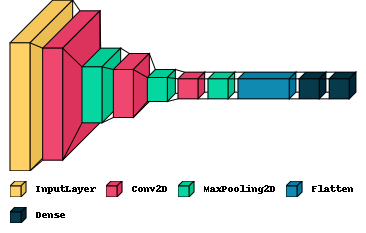

In [46]:
visualkeras.layered_view(old_model, legend=True)

*-Use BatchNormalization layers:* <br>
Normalizing the inputs of some layer could help to reduce overfitting, we are going to add a batch normalization layer after each maxpooling layer and that's to normalize the inputs of each of the next convolutional layer or the inputs of the fully connected layer after the last convolution.

In [47]:
if test_reg == True:
    names.append("Reg_normalization")
    model = get_best_test_model()
    new_model = Sequential()
    for layer in model.layers:
        if (type(layer) is layers.MaxPooling2D):
            new_model.add(layers.BatchNormalization())
        new_model.add(layer)

    test_models.append(new_model)

![Test_ batch normalization training and validation](images/gender/Regularization/Reg_normalization.png)

Another technique we could use is data augmentation which consist on increasing the number of the training images and that's by creating different images by applying transoformations like fliiping or rotating. With this we can have provide the model with more unseen data from our original images. 

In [48]:
if test_reg == True:
    names.append("Reg_DataAugmentation")
    model = get_best_test_model()
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )

    new_model = Sequential()
    new_model.add(data_augmentation)
    for layer in model.layers:
        new_model.add(layer)

    test_models.append(new_model)

![Test data augmentation training and validation](images/gender/Regularization/Reg_DataAugmentation.png)

Another technique to prevent the model from overfitting is dropout. The first architecture will conisit of using just one dropout layer after the flatten layer; it randomly drops out some of the features before passing them to the fully connected layer. That's to make the model not relying too much on certain features and pushes it to learn more instead of memorizing what it saw.

In [49]:
if test_reg == True:
    names.append("Reg_dropout_fl")
    model = get_best_test_model()
    new_model = Sequential()
    count = 0
    for layer in model.layers:
        new_model.add(layer)
        if (type(layer) is layers.Flatten):
            new_model.add(layers.Dropout(0.5, name="Layer_" + str(count)))
            count = count + 1

    test_models.append(new_model)

![Test_drpout fl training and validation](images/gender/Regularization/Reg_dropout_fl.png)

In this architecture we used a dropout layer after each maxpooling layer in addition to the flatten layer. By using a dropout layer in multiple levels of the network we can improve more the model's ability to generalize new data and prevent overfitting.

In [50]:
if test_reg == True:
    names.append("Reg_dropout_mx")
    model = get_best_test_model()

    new_model = Sequential()
    for layer in model.layers:
        new_model.add(layer)
        if (type(layer) is layers.Flatten or type(layer) is layers.MaxPooling2D):
            new_model.add(layers.Dropout(0.5))

    test_models.append(new_model)

![Test_dropout mx training and validation](images/gender/Regularization/Reg_dropout_mx.png)

We use only L2 regularization as it gives us the best results in previous iteration. Other possible options where be L1 and l1_l2 but we remove them to do not lose time testing them.

In [ ]:
#if test_reg == True:
#    names.append("Reg_L1")
#    model = get_best_test_model()
#    new_model = Sequential()
#    for layer in model.layers:
#        if (type(layer) is layers.Conv2D):
#            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
#                                        activation=layer.activation, kernel_regularizer=regularizers.l1(0.001)))
#        else:
#            new_model.add(layer)

#    test_models.append(new_model)

In [51]:
if test_reg == True:
    names.append("Reg_L2")
    model = get_best_test_model()
    new_model = Sequential()
    for layer in model.layers:
        if (type(layer) is layers.Conv2D):
            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
                                        activation=layer.activation, kernel_regularizer=regularizers.l2(0.001)))
        else:
            new_model.add(layer)

    test_models.append(new_model)

![Test_reg l2 training and validation](images/gender/Regularization/Reg_L2.png)

In [ ]:
#if test_reg == True:
#    names.append("Reg_L1_L2")
#    model = get_best_test_model()
#    new_model = Sequential()
#    for layer in model.layers:
#        if (type(layer) is layers.Conv2D):
#            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
#                                        activation=layer.activation, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
#        else:
#            new_model.add(layer)

#    test_models.append(new_model)

Other possible regularization technique is the use of initializers. As in the past we tested this kind of technique without good results and conv2d layers use by default the glorot_uniform, we decided just to leave this one and do not implement other initializers.

Next we test some combinations to see if we get better results that individually. We did not test dropout at the same time that batch normalization as they do not work well together. Dropout could randomly drop out neurons that normalization is taking into account to makes its calculations.

In [53]:
if test_reg == True:
    names.append("Reg_L2DropOut")
    model = get_best_test_model()
    new_model = Sequential()
    for layer in model.layers:
        if (type(layer) is layers.Conv2D):
            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
                                        activation=layer.activation, kernel_regularizer=regularizers.l2(0.001)))
        else:
            new_model.add(layer)
            if (type(layer) is layers.Flatten or type(layer) is layers.MaxPooling2D):
                new_model.add(layers.Dropout(0.5))

    test_models.append(new_model)

![Test_l2 dropout training and validation](images/gender/Regularization/Reg_L2DropOut.png)

In [54]:
if test_reg == True:
    names.append("Reg_L2Normalization")
    model = get_best_test_model()
    new_model = Sequential()
    for layer in model.layers:
        if (type(layer) is layers.Conv2D):
            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
                                        activation=layer.activation, kernel_regularizer=regularizers.l2(0.001)))
            new_model.add(layers.BatchNormalization())
        else:
            new_model.add(layer)

    test_models.append(new_model)

![Test_reg l2 normalization training and validation](images/gender/Regularization/Reg_L2normalization.png)

In [55]:
if test_reg == True:
    names.append("Reg_Drop_l2")
    model = get_best_test_model()
    new_model = Sequential()
    for layer in model.layers:
        if (type(layer) is layers.Conv2D):
            new_model.add(layers.Conv2D(filters=layer.filters, kernel_size=layer.kernel_size, 
                                        activation=layer.activation, kernel_regularizer=regularizers.l2(0.001)))
            new_model.add(layers.Dropout(0.5))
        else:
            new_model.add(layer)

    test_models.append(new_model)


![Test_drop l2 training and validation](images/gender/Regularization/Reg_Drop_l2.png)

In [56]:
if test_reg == True:
    for i in range(0,len(names)):
        print("Testing model:",names[i])
        test_models[i].compile(optimizer=get_optimizer(),loss="binary_crossentropy", weighted_metrics=["accuracy"])
        test_history.append(test_models[i].fit(ds_train_batch, epochs=100, validation_data=ds_test_batch, callbacks=get_callbacks(names[i])))

In [57]:
if test_reg == True:
    for i in range(0,len(names)):
        print_plot(names[i], test_history[i])
        min_loss = min(test_history[i].history['val_loss'])
        epoch = 0

        for x in range(0, len(test_history[i].history['val_loss'])):
            if test_history[i].history['val_loss'][x] == min_loss:
                epoch = x + 1
                acc = test_history[i].history['val_accuracy'][x]

        print("Model:", names[i], "- Epoch:", epoch, "- Model accuracy:", acc, "- Best accuracy:", max(test_history[i].history['val_accuracy']))

As we can see in the above code, we tested several different regularization techniques. The models and graph images of the last tested model are available in a separate folder. 

For future executions of the notebook, we use the variable test_reg in false to not repeat this test.

### Optimizing learning rate

In this section we do the fine tuning of the best regularizated model. After experimenting with different models and regularization techniques, we selected the model to "tune it", this means, we train the model with a optimizer learning rate and iterate with lower values, so it gets the best possible loss. For this we create the model and use the modalcheckpoint as an auxiliar to save only the best of each iteration.

First we show the summary of the selected model to fine tune:

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                           

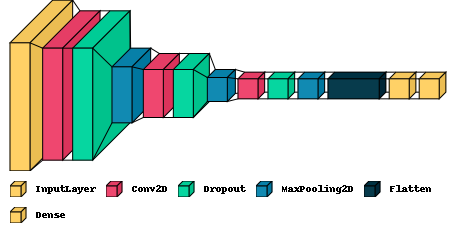

In [58]:
final_hist = []
final_model = get_best_reg_model()
final_model.summary()

visualkeras.layered_view(final_model, legend=True)

In [59]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="models/fine_tunning001.keras",save_best_only=True,monitor="val_loss", verbose=1), late_stop]
final_model.compile(optimizer=get_optimizer(),loss="binary_crossentropy", weighted_metrics=["accuracy"])
hist = final_model.fit(ds_train_batch, epochs=120, validation_data=ds_test_batch, callbacks=callbacks)

Epoch 1/120
992/992 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7593
Epoch 1: val_loss improved from inf to 0.60958, saving model to models\fine_tunning001.keras
992/992 [==============================] - 23s 21ms/step - loss: 0.5846 - accuracy: 0.7593 - val_loss: 0.6096 - val_accuracy: 0.8173
Epoch 2/120
989/992 [============================>.] - ETA: 0s - loss: 0.4646 - accuracy: 0.8209
Epoch 2: val_loss improved from 0.60958 to 0.55695, saving model to models\fine_tunning001.keras
992/992 [==============================] - 22s 22ms/step - loss: 0.4646 - accuracy: 0.8209 - val_loss: 0.5570 - val_accuracy: 0.7776
Epoch 3/120
990/992 [============================>.] - ETA: 0s - loss: 0.4199 - accuracy: 0.8368
Epoch 3: val_loss improved from 0.55695 to 0.52303, saving model to models\fine_tunning001.keras
992/992 [==============================] - 22s 22ms/step - loss: 0.4200 - accuracy: 0.8367 - val_loss: 0.5230 - val_accuracy: 0.8105
Epoch 4/120
992/992 [==

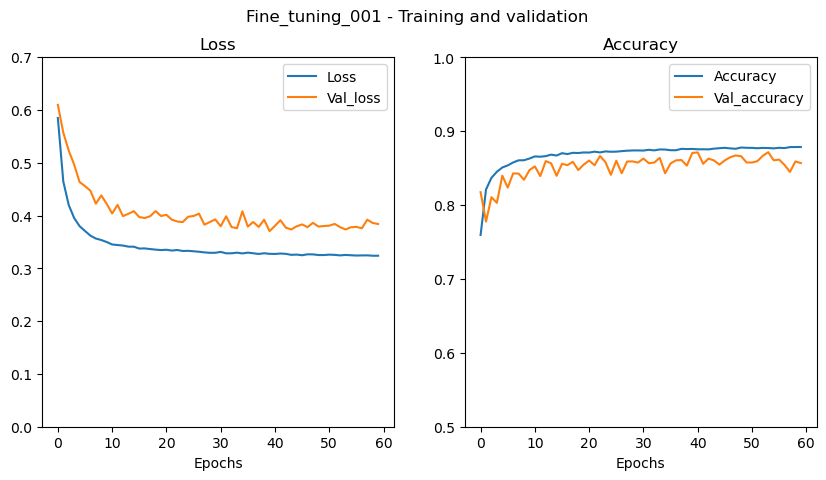

Epoch: 40 - Model accuracy: 0.8703081607818604 - Best accuracy: 0.8713840842247009


In [60]:
print_plot("Fine_tuning_001", hist)
min_loss = min(hist.history['val_loss'])
epoch = 0

for x in range(0, len(hist.history['val_loss'])):
    if hist.history['val_loss'][x] == min_loss:
        epoch = x + 1
        acc = hist.history['val_accuracy'][x]

print("Epoch:", epoch, "- Model accuracy:", acc, "- Best accuracy:", max(hist.history['val_accuracy']))

In [61]:
tune_model = load_model("models/fine_tunning001.keras")
callbacks = [keras.callbacks.ModelCheckpoint(filepath="models/fine_tunning00001.keras",save_best_only=True,monitor="val_loss", verbose=1), late_stop]
tune_model.compile(optimizer=optimizers.Adamax(0.0001),loss="binary_crossentropy", weighted_metrics=["accuracy"])
hist = tune_model.fit(ds_train_batch, epochs=120, validation_data=ds_test_batch, callbacks=callbacks)

Epoch 1/120
991/992 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8826
Epoch 1: val_loss improved from inf to 0.37154, saving model to models\fine_tunning00001.keras
992/992 [==============================] - 23s 22ms/step - loss: 0.3152 - accuracy: 0.8826 - val_loss: 0.3715 - val_accuracy: 0.8646
Epoch 2/120
990/992 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8848
Epoch 2: val_loss improved from 0.37154 to 0.36955, saving model to models\fine_tunning00001.keras
992/992 [==============================] - 21s 22ms/step - loss: 0.3110 - accuracy: 0.8848 - val_loss: 0.3695 - val_accuracy: 0.8674
Epoch 3/120
992/992 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8850
Epoch 3: val_loss did not improve from 0.36955
992/992 [==============================] - 22s 22ms/step - loss: 0.3099 - accuracy: 0.8850 - val_loss: 0.3742 - val_accuracy: 0.8641
Epoch 4/120
991/992 [============================>.] - ETA: 0s - loss

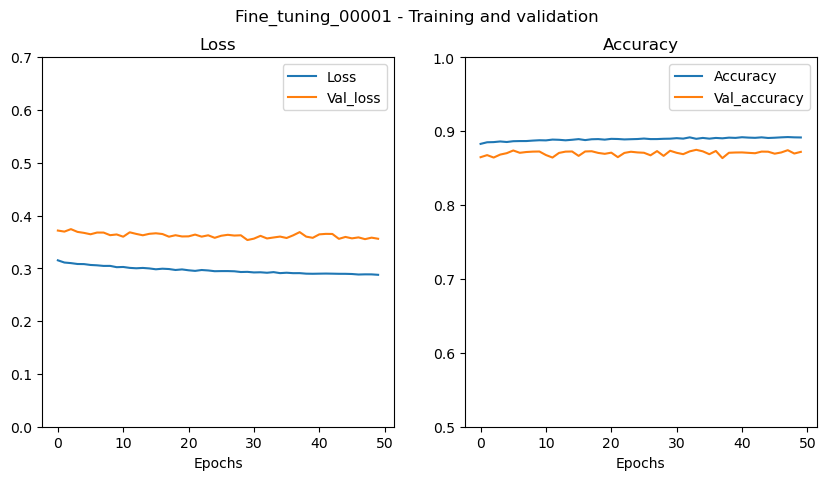

Epoch: 30 - Model accuracy: 0.8733320236206055 - Best accuracy: 0.874612033367157


In [62]:
print_plot("Fine_tuning_00001", hist)
min_loss = min(hist.history['val_loss'])
epoch = 0

for x in range(0, len(hist.history['val_loss'])):
    if hist.history['val_loss'][x] == min_loss:
        epoch = x + 1
        acc = hist.history['val_accuracy'][x]

print("Epoch:", epoch, "- Model accuracy:", acc, "- Best accuracy:", max(hist.history['val_accuracy']))

In [63]:
tune_model = load_model("models/fine_tunning00001.keras")
callbacks = [keras.callbacks.ModelCheckpoint(filepath="models/best_model.keras",save_best_only=True,monitor="val_loss", verbose=1), late_stop]
tune_model.compile(optimizer=optimizers.Adamax(0.00001),loss="binary_crossentropy", weighted_metrics=["accuracy"])
hist = tune_model.fit(ds_train_batch, epochs=120, validation_data=ds_test_batch, callbacks=callbacks)

Epoch 1/120
990/992 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8913
Epoch 1: val_loss improved from inf to 0.35784, saving model to models\best_model.keras
992/992 [==============================] - 22s 21ms/step - loss: 0.2914 - accuracy: 0.8914 - val_loss: 0.3578 - val_accuracy: 0.8725
Epoch 2/120
991/992 [============================>.] - ETA: 0s - loss: 0.2908 - accuracy: 0.8910
Epoch 2: val_loss did not improve from 0.35784
992/992 [==============================] - 20s 21ms/step - loss: 0.2908 - accuracy: 0.8910 - val_loss: 0.3608 - val_accuracy: 0.8724
Epoch 3/120
990/992 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.8917
Epoch 3: val_loss did not improve from 0.35784
992/992 [==============================] - 22s 22ms/step - loss: 0.2902 - accuracy: 0.8917 - val_loss: 0.3589 - val_accuracy: 0.8741
Epoch 4/120
989/992 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8907
Epoch 4: val_loss did not impro

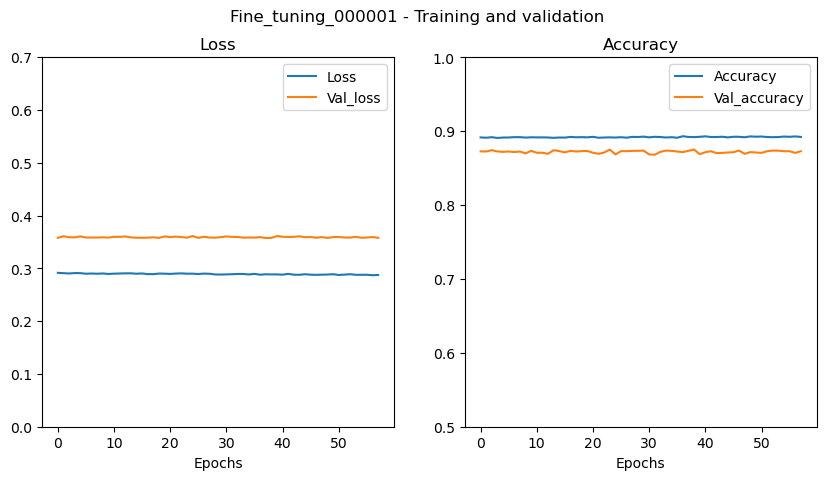

Epoch: 38 - Model accuracy: 0.8732268214225769 - Best accuracy: 0.8749707341194153


In [64]:
print_plot("Fine_tuning_000001", hist)
min_loss = min(hist.history['val_loss'])
epoch = 0

for x in range(0, len(hist.history['val_loss'])):
    if hist.history['val_loss'][x] == min_loss:
        epoch = x + 1
        acc = hist.history['val_accuracy'][x]

print("Epoch:", epoch, "- Model accuracy:", acc, "- Best accuracy:", max(hist.history['val_accuracy']))

## 4.Results

In this section we show the final results

Test model - Acc: 85.92
Test model with reg - Acc: 87.06
Test model finetuning - Acc: 87.32


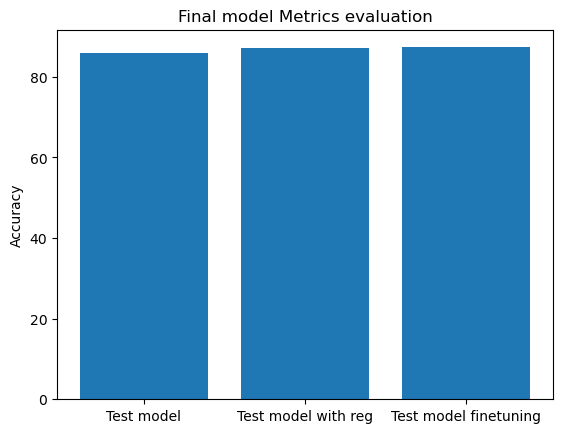

In [67]:
acc_models = [85.92, 87.06, 87.32]
acc_names = ["Test model", "Test model with reg", "Test model finetuning"]

for i in range(0,len(acc_names)):
    print(acc_names[i], '- Acc:', acc_models[i])

plt.bar(acc_names,acc_models)
plt.title('Final model Metrics evaluation')
plt.ylabel('Accuracy')
plt.show()

In the above graphic we can see the evolution of our model two the three steps that we set for our selection, first the test of different arquitectures, then the test of different regularization techniques on those models and finally the fine tunning of our final model.

As stated before, better validation accuracy metrics have been obtained, but we decide to use the ones that correspond to the lowest loss value. In the final execution of our model, the validation accuracy was 87.32.